In [1]:
import pandas as pd
import numpy as np
import os

### Data

In [2]:
path = '../../../data/'
data1 = pd.read_csv(path +'201901-202003.csv')
data1 = data1.fillna('')
data2 = pd.read_csv(path +'202004.csv')
data2 = data2.fillna('')

In [3]:
# data = pd.concat([data1, data2])
data = data1

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24697792 entries, 0 to 24697791
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   REG_YYMM      int64 
 1   CARD_SIDO_NM  object
 2   CARD_CCG_NM   object
 3   STD_CLSS_NM   object
 4   HOM_SIDO_NM   object
 5   HOM_CCG_NM    object
 6   AGE           object
 7   SEX_CTGO_CD   int64 
 8   FLC           int64 
 9   CSTMR_CNT     int64 
 10  AMT           int64 
 11  CNT           int64 
dtypes: int64(6), object(6)
memory usage: 2.2+ GB


#### 결측 처리

In [5]:
data.loc[data.CARD_CCG_NM.isna(),'CARD_CCG_NM'] = '세종'
data.loc[data.HOM_CCG_NM.isna(),'HOM_CCG_NM'] = '세종'

#### 18 사업체총조사

In [6]:
path2 = '../../../data/외부데이터/'

In [7]:
all_jobs_df = pd.read_csv(path2 +'18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

all_jobs_df = all_jobs_df[~(all_jobs_df.CARD_SIDO_NM == '전국')]

#### 지역내 각 업종이 차지하는 매출비중

In [8]:
def local_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    #각 지역별(시군구)업종의 매출비율을 저장
    sidos = pivoted.CARD_SIDO_NM.unique()

    local_percent_df = pd.DataFrame()
    for sido in sidos:
        sample_sido = pivoted[pivoted.CARD_SIDO_NM == sido]
        sigungus = sample_sido.CARD_CCG_NM.unique()
        for sigungu in sigungus:
            sample = sample_sido[sample_sido.CARD_CCG_NM == sigungu]
            sum_arr = sample.iloc[:,3:].sum().values.reshape(1,-1)
            parcent_df = (sample.iloc[:,3:]/sum_arr)*100

            fin = pd.concat([sample.iloc[:,:3],parcent_df],axis=1)
            local_percent_df = pd.concat([local_percent_df,fin])

    #신규변수 LP(local percent) : 지역내 각 업종이 차지하는 매출비중
    local_percent_df = local_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='LP')
    return local_percent_df

#### 전체업종에서 각 지역업종이 차지하는 매출비중

In [9]:
def job_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    all_pivoted = data.pivot_table(index = ['STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc= 'sum').reset_index()
    all_pivoted.fillna(0,inplace= True)
    all_pivoted = all_pivoted.set_index('STD_CLSS_NM')

    job_percent_df = pd.DataFrame()
    for job in all_pivoted.index:
        taget_df = pivoted[pivoted.STD_CLSS_NM == job]
        tail = (taget_df.iloc[:,3:]/all_pivoted.iloc[0].values)*100
        head = taget_df.iloc[:,:3]
        full = pd.concat([head,tail],axis =1)
        job_percent_df = pd.concat([job_percent_df,full])

    #신규변수 JP(Job percent): 전체업종에서 해당지역의 업종이 차이하는 비율
    job_percent_df = job_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='JP')
    return job_percent_df

In [10]:
local_percent_df = local_percent(data)
job_percent_df = job_percent(data)

#### 거래횟수와 이용고객과의 관계 (2019)

In [11]:
def cust_differ(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[4:]))
    
    #2019만 사용
    melt_plus = melt_plus[melt_plus.year == 2019]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[4:]))
    #2019만 사용
    melt_minus = melt_minus[melt_minus.year == 2019]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [12]:
trade_num_2019 = cust_differ(data)

#### 거래횟수와 이용고객과의 관계 (2020)

In [13]:
def cust_differ_2020(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[4:]))
    
    #2020만 사용
    melt_plus = melt_plus[melt_plus.year == 2020]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[4:]))
    #2020만 사용
    melt_minus = melt_minus[melt_minus.year == 2020]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [14]:
trade_num_2020 = cust_differ_2020(data)

In [15]:
trade_num = pd.concat([trade_num_2019, trade_num_2020])

In [16]:
# trade_num.loyal = trade_num.loyal.fillna(-999)
# trade_num.refund = trade_num.refund.fillna(999)

In [17]:
trade_num

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,loyal,month,refund
0,강원,건강보조식품 소매업,201901.0,80.0,1,-32.0
1,강원,골프장 운영업,201901.0,14890.0,1,NaN
2,강원,과실 및 채소 소매업,201901.0,7484.0,1,NaN
3,강원,관광 민예품 및 선물용품 소매업,201901.0,195.0,1,NaN
4,강원,그외 기타 분류안된 오락관련 서비스업,201901.0,NaN,1,NaN
...,...,...,...,...,...,...
1930,충북,화장품 및 방향제 소매업,202003.0,1294.0,3,-9.0
1931,충북,휴양콘도 운영업,202003.0,67.0,3,NaN
1932,대전,여행사업,202001.0,NaN,1,NaN
1933,대전,여행사업,202002.0,NaN,2,NaN


#### 추가변수 결합

In [18]:
data.shape

(24697792, 13)

In [19]:
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']
df = data.groupby(columns, as_index=False)[['AMT']].sum()

In [20]:
grouped = pd.merge(df,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
grouped = pd.merge(grouped,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped, trade_num, on =['CARD_SIDO_NM','STD_CLSS_NM','REG_YYMM'], how = 'left')

In [21]:
grouped.shape

(5328210, 16)

In [22]:
grouped.columns

Index(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',
       'AGE', 'SEX_CTGO_CD', 'FLC', 'AMT', 'company', 'employee', 'LP', 'JP',
       'loyal', 'month', 'refund'],
      dtype='object')

In [23]:
grouped.REG_YYMM = pd.to_datetime(grouped.REG_YYMM, format='%Y%m')

In [24]:
from sklearn.preprocessing import LabelEncoder

# 인코딩
dtypes = grouped.dtypes
encoders = {}
for column in grouped.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(grouped[column])
        encoders[column] = encoder
        
df_num = grouped.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(grouped[column])

In [25]:
df_num

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,2019-01-01,0,4,0,0,2,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,2019-01-01,0,4,0,0,2,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,2019-01-01,0,4,0,0,3,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,2019-01-01,0,4,0,0,3,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5328205,2020-03-01,16,202,40,16,2,1,2,43300,11.0,492.0,0.004484,0.010694,67.0,3.0,NaN
5328206,2020-03-01,16,202,40,16,3,1,3,35000,11.0,492.0,0.004484,0.010694,67.0,3.0,NaN
5328207,2020-03-01,16,202,40,16,4,1,4,188000,11.0,492.0,0.004484,0.010694,67.0,3.0,NaN
5328208,2020-03-01,16,202,40,16,4,2,4,99000,11.0,492.0,0.004484,0.010694,67.0,3.0,NaN


In [26]:
import datetime as dt

df_num['month'] = df_num['REG_YYMM'].dt.month
df_num['year'] = df_num['REG_YYMM'].dt.year

In [27]:
train_df = df_num[df_num['REG_YYMM'] <= '2020-01-01']
validation_df = df_num[(df_num['REG_YYMM'] > '2020-01-01') & (df_num['REG_YYMM'] <'2020-04-01')]

In [28]:
# 7월 데이터 = 2020년의 평균값을 사용.

temp = df_num[df_num['REG_YYMM'] >= '2020']
temp = temp.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()

In [29]:
temp

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,company,employee,LP,JP,loyal,month,refund,year
0,0,4,0,0,1,2,1,263.0,399.0,0.142702,0.254024,93.000000,1.0,-44.000000,2020.0
1,0,4,0,0,2,1,2,263.0,399.0,0.108962,0.238864,71.000000,2.0,-33.666667,2020.0
2,0,4,0,0,2,2,2,263.0,399.0,0.142702,0.254024,93.000000,1.0,-44.000000,2020.0
3,0,4,0,0,3,1,3,263.0,399.0,0.108962,0.238864,71.000000,2.0,-33.666667,2020.0
4,0,4,0,0,3,1,4,263.0,399.0,0.142702,0.254024,93.000000,1.0,-44.000000,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411736,16,202,40,16,3,1,4,11.0,492.0,0.078091,0.117169,1367.000000,1.0,-9.000000,2020.0
411737,16,202,40,16,3,2,3,11.0,492.0,0.047749,0.079103,846.500000,1.5,-5.000000,2020.0
411738,16,202,40,16,4,1,4,11.0,492.0,0.033327,0.056300,586.666667,2.0,-5.000000,2020.0
411739,16,202,40,16,4,2,4,11.0,492.0,0.033327,0.056300,586.666667,2.0,-5.000000,2020.0


In [30]:
df_num[df_num['REG_YYMM'] == '2020-04-01']

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund,year


In [31]:
temp.month = 4
# temp = pd.concat([df_num[df_num['REG_YYMM'] == '2020-04-01'], temp])

In [32]:
temp

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,company,employee,LP,JP,loyal,month,refund,year
0,0,4,0,0,1,2,1,263.0,399.0,0.142702,0.254024,93.000000,4,-44.000000,2020.0
1,0,4,0,0,2,1,2,263.0,399.0,0.108962,0.238864,71.000000,4,-33.666667,2020.0
2,0,4,0,0,2,2,2,263.0,399.0,0.142702,0.254024,93.000000,4,-44.000000,2020.0
3,0,4,0,0,3,1,3,263.0,399.0,0.108962,0.238864,71.000000,4,-33.666667,2020.0
4,0,4,0,0,3,1,4,263.0,399.0,0.142702,0.254024,93.000000,4,-44.000000,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411736,16,202,40,16,3,1,4,11.0,492.0,0.078091,0.117169,1367.000000,4,-9.000000,2020.0
411737,16,202,40,16,3,2,3,11.0,492.0,0.047749,0.079103,846.500000,4,-5.000000,2020.0
411738,16,202,40,16,4,1,4,11.0,492.0,0.033327,0.056300,586.666667,4,-5.000000,2020.0
411739,16,202,40,16,4,2,4,11.0,492.0,0.033327,0.056300,586.666667,4,-5.000000,2020.0


In [33]:
# temp = temp.drop(['REG_YYMM', 'AMT'], axis=1)

KeyError: "['REG_YYMM' 'AMT'] not found in axis"

### Light GBM

In [37]:
import lightgbm as lgb

In [38]:
train_df.head(1)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund,year
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019


In [39]:
train = train_df.drop(['AMT', 'REG_YYMM'], axis=1)
trian_label = np.log1p(train_df[['AMT']])

In [40]:
validation = validation_df.drop(['AMT', 'REG_YYMM'], axis=1)
validation_label = np.log1p(validation_df[['AMT']])

In [41]:
lgb_train = lgb.Dataset(train, label=trian_label)
lgb_eval = lgb.Dataset(validation, label=validation_label, reference=lgb_train)

In [42]:
evals_result = {}
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth':11,
    'num_leaves': 31,
    'learning_rate': 0.7,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}

In [43]:
model = lgb.train(params, lgb_train, early_stopping_rounds=100,
                  num_boost_round=5000, evals_result=evals_result,
                  valid_sets= (lgb_train, lgb_eval),verbose_eval = 100)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.06542	valid_1's rmse: 1.13391
[200]	training's rmse: 0.968093	valid_1's rmse: 1.0681
[300]	training's rmse: 0.916798	valid_1's rmse: 1.03733
[400]	training's rmse: 0.877441	valid_1's rmse: 1.01613
[500]	training's rmse: 0.847424	valid_1's rmse: 0.998869
[600]	training's rmse: 0.825902	valid_1's rmse: 0.989734
[700]	training's rmse: 0.809353	valid_1's rmse: 0.9814
[800]	training's rmse: 0.792706	valid_1's rmse: 0.975166
[900]	training's rmse: 0.780115	valid_1's rmse: 0.968761
[1000]	training's rmse: 0.768941	valid_1's rmse: 0.964107
[1100]	training's rmse: 0.759479	valid_1's rmse: 0.960134
[1200]	training's rmse: 0.751245	valid_1's rmse: 0.957122
[1300]	training's rmse: 0.742861	valid_1's rmse: 0.956132
[1400]	training's rmse: 0.736596	valid_1's rmse: 0.953318
[1500]	training's rmse: 0.730354	valid_1's rmse: 0.950285
[1600]	training's rmse: 0.724177	valid_1's rmse: 0.949527
[1700]	training's rmse: 0.7

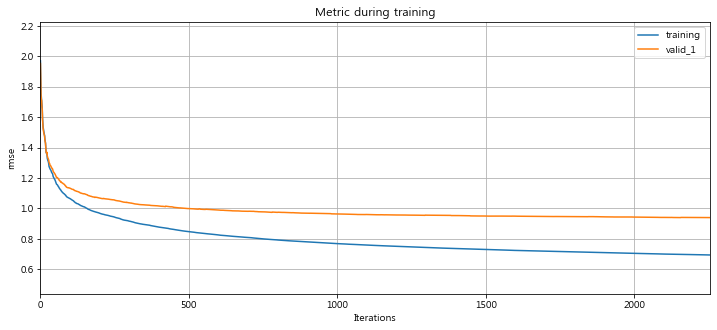

In [44]:
import matplotlib as mlt
import matplotlib.pyplot as plt
%matplotlib inline

lgb.plot_metric(evals_result, figsize=(12, 5))

In [45]:
pd.DataFrame({'name': model.feature_name(), 'importance':model.feature_importance()}).sort_values('importance',ascending= False)

,name,importance
3,HOM_SIDO_NM,10903
1,CARD_CCG_NM,9242
10,JP,6419
9,LP,5652
4,AGE,4842
11,loyal,4603
0,CARD_SIDO_NM,4113
7,company,3909
8,employee,3561
2,STD_CLSS_NM,3075


In [46]:
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [47]:
# 디코딩 (Random Forest)
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [48]:
# 제출 파일 만들기(Random Forest)
submission = pd.read_csv(path +'submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
compare_pred = submission.dropna()
submission = submission.fillna(0)
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,1.510287e+08
1,202004,강원,골프장 운영업,1.875271e+09
2,202004,강원,과실 및 채소 소매업,9.990152e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,2.366080e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


In [49]:
submission

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,1.510287e+08
1,202004,강원,골프장 운영업,1.875271e+09
2,202004,강원,과실 및 채소 소매업,9.990152e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,2.366080e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00
...,...,...,...,...
1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,0.000000e+00
1390,202007,충북,한식 음식점업,0.000000e+00
1391,202007,충북,호텔업,0.000000e+00


In [50]:
path3 = '../../../'
only_4 = pd.read_csv(path3+'only_4.csv')
def set_sumit(only_4, pre_df):
    '''리더보드와 동일한 예측을 하는 함수
    parameter
    --------
    only_4(df) : 4월 RMSLE가 0이 나왔던 제출셋
    pre_df(df) : 모델로 예측한 Dataframe
    
    '''
    from sklearn.metrics import mean_squared_log_error
    
    pre_df = pre_df[pre_df['REG_YYMM'] == 202004]
    only_4 = only_4[only_4['REG_YYMM'] == 202004]
    
    pre_df.loc[pre_df.CARD_SIDO_NM == '제주','weight'] = 3
    pre_df.loc[pre_df.CARD_SIDO_NM != '제주','weight'] = 1
    
    weight = pre_df['weight'].values
    
    all_amt = np.sqrt(mean_squared_log_error(only_4['AMT'],pre_df['AMT'],sample_weight=weight))
    return all_amt

In [51]:
set_sumit(only_4, submission)

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2.541485244424558